/Users/austinmbaye/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


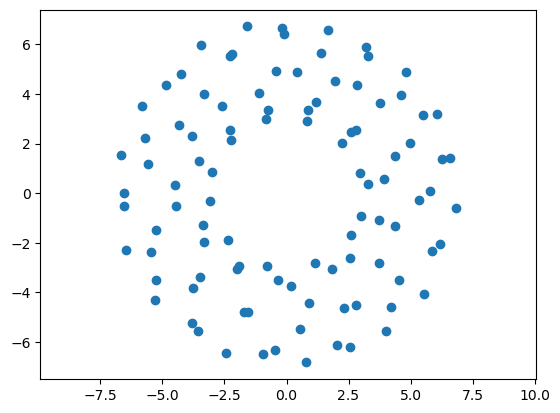

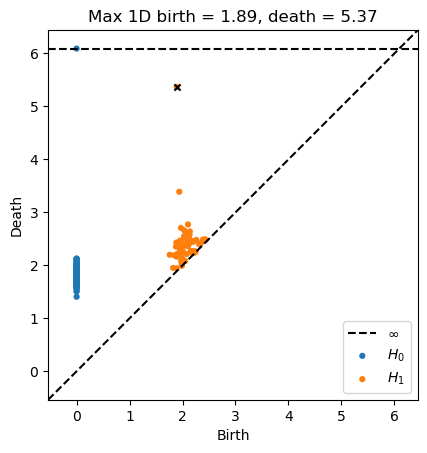

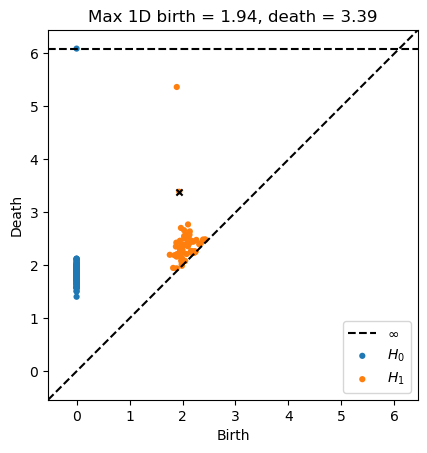

rc
79
cc2
79
edges in common
7
58504
79
79
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
79
28.580907106399536


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import tadasets
%matplotlib inline


start_time = time.time()
#Here we are just generating a torus
np.random.seed(2)
n_data = 25000
R = 5
r = 2
data = np.zeros((3, n_data))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi

data[0] = (R + r*np.cos(s))*np.cos(t)
data[1] = (R + r*np.cos(s))*np.sin(t)
data[2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)


#This is sampling to reduce the number of points that I have to work with
from sklearn.cluster import KMeans

def kmeans_downsampling(data, num_points):
    # Perform k-means clustering on the data
    kmeans = KMeans(n_clusters=num_points, random_state=0).fit(data)
    
    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_
    
    return centroids

# Set the desired number of points after downsampling
num_points = 100 #This seems to be a good sample size that keeps al of the important data

# Perform k-means downsampling on the data
x = kmeans_downsampling(data.T, num_points)


#This is just to get everything ready
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')
plt.show()
result = ripser(x, coeff=17, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles'] #all of the cocycles
D = result['dperm2all'] #distance matrix between the ith and jth points in the data
dgm1 = diagrams[1]


#This is the start for the highest point in the persistence diagram
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()
cocycle1 = cocycles[1][idx] #I think that this is the representative cocycle for the highest point

#Now we just have to find the representative cocycle for psi so we have to look for the second highest point
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
idx = sorted_indices[-2] #this will give me the second highest persistent point
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()
cocycle2 = cocycles[1][idx] #I think that this is the representative cocyle for the second highest persistent point


#For cocycle1 we want to restrict it to cocycle2


New_cocycle1=[]
edges=[]
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]): #This checks to see if there are any edges in common 
                New_cocycle1.append(cocycle2[j:j+1])
        New_cocycle1.append(cocycle2[i:i+1])        
rcocycle1=np.vstack(New_cocycle1)

#Now I have to go back to collect the edges in common:

for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                edges.append(cocycle2[j:j+1])
                
edges=np.vstack(edges)



#Finally I have to make the rows that are not equal to any of the edges columns be zero
for i in range(len(rcocycle1)):
    found_match = False

    for j in range(len(edges)):
        if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
            found_match = True
            break

    if not found_match:
        rcocycle1[i, -1] = 0

        
print("rc")            

print(len(rcocycle1))
print("cc2")

print(len(cocycle2))
print("edges in common")

print(len(edges))
#Checking to see if the dimensions are correct


#Ok ok now we can start taking the cup product

#so we have phi and psi, now we need to extract every traingle {a,b,c} then take phi(rcocycle1) of the first two {a,b} then psi(cocycle2) of the last two verticies {b,c}

#First we have to get all of the triangles:

# Finding the representative cocycles for triangles
from itertools import combinations

representative_cocycles = []

for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  # ignore points on the diagonal
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)

# Extracting every triangle as an array of vertices
triangles = []

for cocycle in representative_cocycles:
    edge_indices = cocycle[:, :2].astype(int)
    triangle_vertices = set()
    
    for i, j in edge_indices:
        triangle_vertices.add(i)
        triangle_vertices.add(j)
    
    # Generate all combinations of 3 vertices
    triangle_combinations = combinations(triangle_vertices, 3)
    
    for combination in triangle_combinations:
        triangles.append(list(combination))


t=np.vstack(triangles)
print(len(t))


# Now we can try the cup product

# First, let's do phi
cup_rc1 = []

for i in range(len(rcocycle1)):
    found_match = False

    for j in range(len(t)):
        if np.array_equal(rcocycle1[i, :2], t[j, :2]):
            found_match = True
            cup_rc1.append(rcocycle1[i, 2:3])
            break

    if not found_match:
        rcocycle1[i, 2:3] = 0
        cup_rc1.append(rcocycle1[i,2:3])
        
c1 = np.vstack(cup_rc1)
print(len(c1))
#print(c1)

#I guess try psi

# First, let's do phi
cup_rc2 = []

for i in range(len(rcocycle1)):
    found_match = False

    for j in range(len(t)):
        if np.array_equal(rcocycle1[i, :2], t[j, 1:3]):
            found_match = True
            cup_rc2.append(rcocycle1[i, 2:3])
            break

    if not found_match:
        rcocycle1[i, 2:3] = 0
        cup_rc2.append(rcocycle1[i,2:3])
        
c2 = np.vstack(cup_rc2)
print(len(c2))

#Now lets cup the two by taking the component wise multiplication of the two vectors
cup_product=[]
for i in range(len(c1)):
    x=(c1[i]*c2[i])%2
    cup_product.append(x)
    
cup=np.vstack(cup_product)
print(cup)
print(len(cup))
    

time_e=time.time()-start_time
print(time_e)
